#### load libraries

In [4]:
import os
import time
import torch
import numpy as np
import torch.nn as nn

os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
import imp
from cell import  utils, plot_utils, analysis, graph_utils

imp.reload(utils)
imp.reload(plot_utils)
imp.reload(analysis)

<module 'cell.analysis' from '/Users/fahimehb/Documents/git-workspace/celltypes/cell/analysis.py'>

### run properties

In [8]:
#walk properties
N = 1
length = 10000

#walk filename
walk_filename = "walk_node21_32_removed.csv"

#Directories
roi = "VISp"
layer_class = "single_layer"
project_name = "NPP_GNN_project"
layer = "base_unnormalized_allcombined"
walk_type = "Directed_Weighted_node2vec"

#run hyperparams
window = 2
n_epochs = 5000
num_workers = 4
batch_size = 2000
embedding_size = 2
learning_rate = 0.00001
opt_add = "node21_32_removed"
CBOW = True

### Get model and loss file path

In [9]:
def get_model_loss_path(embedding_size, project_name, roi, N, p, q, layer, 
                        layer_class, walk_type, n_epochs, window, learning_rate, 
                        batch_size, opt_add):
    
    model_dir = utils.get_model_dir(project_name=project_name, 
                                    roi=roi, 
                                    length=length,
                                    N=N,
                                    p=p, 
                                    q=q, 
                                    layer=layer, 
                                    layer_class=layer_class, 
                                    walk_type=walk_type)

    model_name = utils.get_model_name(size=embedding_size, 
                                      iter=n_epochs, 
                                      window=window, 
                                      lr=learning_rate, 
                                      batch_size=batch_size, 
                                      opt_add=opt_add)

    loss_name = utils.get_loss_filename(size=embedding_size,
                                        iter=n_epochs, 
                                        window=window, 
                                        lr=learning_rate, 
                                        batch_size=batch_size,
                                        opt_add=opt_add)

    model_path = os.path.join(model_dir, model_name)
    loss_path = os.path.join(model_dir, loss_name)
    #loss = utils.read_list_from_csv(loss_path)
    #loss = [float(i) for i in loss]
    #print(model_path)
    
    return model_path, loss_path

In [18]:
f"{0.0001:.4f}"

'0.0001'

In [21]:
cldf = utils.read_visp_npp_cldf()

models = {}
losses = {}

for p,q in [(1000000, 0.000001), (0.000001, 1000000)]:
    
    model_name = "_".join(("p", str(p), "q", str(q)))
    model_path, loss_path = get_model_loss_path(embedding_size, 
                                                project_name, 
                                                roi, 
                                                N, 
                                                p, 
                                                q, 
                                                layer, 
                                                layer_class, 
                                                walk_type, 
                                                n_epochs, 
                                                window, 
                                                learning_rate, 
                                                batch_size, 
                                                opt_add)
    model=pd.read_csv(model_path)
    model = model.set_index("cluster_id")
    model = model.merge(cldf, on="cluster_id")
    models[model_name] = model
    
    loss = utils.read_list_from_csv(loss_path)
    loss = [float(l) for l in loss]
    losses[model_name] = loss

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


### plot embeddings:

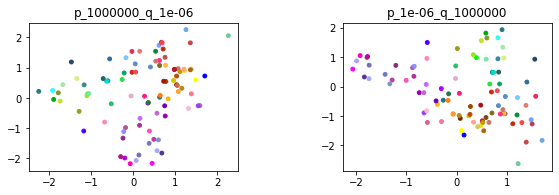

In [22]:
fig = plot_utils.MScatter_plot(datasets=models, 
                              fig_size=(15,60),
                              scatter_point_size=15)

In [45]:
# CMDscale_emb = pd.read_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/CMDscale_emb.csv", 
#                            index_col="cluster_id")

# CMDscale_emb.index = CMDscale_emb.index.astype('str')
# Z_cols = [col for col in CMDscale_emb.columns if 'Z' in col]
# CMDscale_emb = CMDscale_emb[Z_cols + ["cluster_color", "dendcluster_label"]]
# CMDscale_emb = CMDscale_emb.merge(cldf.reset_index(), on="cluster_color")
# CMDscale_emb['cluster_id'] = CMDscale_emb['cluster_id'].astype('str')
# CMDscale_emb = CMDscale_emb.set_index('cluster_id')

In [23]:
jsd_wv_emb_2d = pd.read_csv("/Users/fahimehb/Documents/GNN/dat/jsd_results/wv_2d.csv", 
                      index_col="cluster_id")
jsd_wv_emb_2d.index = jsd_wv_emb_2d.index.astype('str')
Z_cols = [col for col in jsd_wv_emb_2d.columns if 'Z' in col]
jsd_wv_emb_2d = jsd_wv_emb_2d[Z_cols + ["cluster_color", "dendcluster_label"]]
jsd_wv_emb_2d = jsd_wv_emb_2d.merge(cldf.reset_index(), on="cluster_color")
jsd_wv_emb_2d['cluster_id'] = jsd_wv_emb_2d['cluster_id'].astype('str')
jsd_wv_emb_2d = jsd_wv_emb_2d.set_index('cluster_id')

In [24]:
aligned_models = {}
disparities = {}

for k, v in models.items():
#     mtx1, mtx2, disparity = analysis.run_procrustes_analysis(models['p_1_q_1'][["Z0", "Z1"]],
#                                                             v[["Z0", "Z1"]],
#                                                             cl_df=cldf)
    mtx1, mtx2, disparity = analysis.run_procrustes_analysis(jsd_wv_emb_2d.drop(['21', "32"])[["Z0", "Z1"]], 
                                                            v[["Z0", "Z1"]],
                                                            cl_df=cldf)
    disparities[k] = disparity
    aligned_models[k] = mtx2

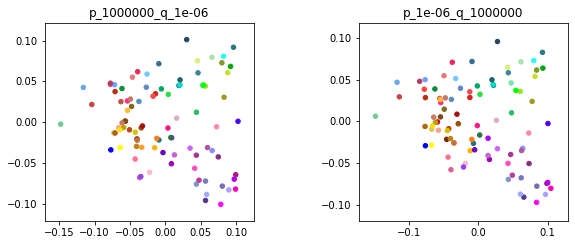

In [25]:
fig = plot_utils.MScatter_plot(datasets=aligned_models,
                              fig_size=(15, 80),
                              scatter_point_size=20)

In [189]:
fig.savefig("/Users/fahimehb/Documents/NPP_GNN_project/figures/hyper_params.png")

In [26]:
disparities

{'p_1000000_q_1e-06': 0.4633278023884428,
 'p_1e-06_q_1000000': 0.47285905563407205}

In [273]:
a = 0.000001
f"{a:f}"

'0.000001'

In [28]:
(0.6360-0.4059 -0.4059-3.0165)/4

-0.7980750000000001

In [274]:
utils.get_walk_dir_name(100, 10, 1000000, 0.000001)

'N_100_l_10_p_1000000_q_0.000001'

In [100]:
np.unique(aligned_models['p_1_q_1']['subclass_label'])

array(['L2/3 IT', 'L4', 'L5 IT', 'L5 PT', 'L6 CT', 'L6 IT', 'L6b',
       'Lamp5', 'NP', 'Pvalb', 'Serpinf1', 'Sncg', 'Sst', 'Vip'],
      dtype=object)

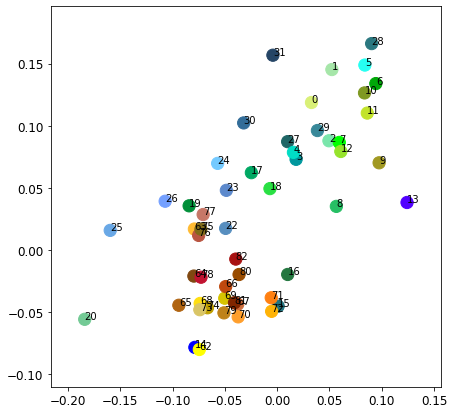

In [249]:
fig=plot_utils.plot_embedding(aligned_models['p_1_q_1'][~aligned_models['p_1_q_1']["subclass_label"].isin(["Pvalb", "Serpinf1","Sncg", "Vip", "Lamp5"])],
                              plot_dim=2,
                              plot_size=(7,7),
                              scatter_point_size=150,
                              annotation = True)

In [241]:
fig.savefig("/Users/fahimehb/Documents/NPP_GNN_project/figures/sst_exc_2d.png", dpi=750)

In [250]:
aligned_models['p_1_q_1'].loc[['82', '22', '19', '77', '38']]

,Z0,Z1,dendcluster_id,cluster_label,colors,cluster_color,subclass_id,subclass_label,subclass_color,class_id,class_label,class_color
cluster_id,,,,,,,,,,,,
82,-0.039560,-0.007286,105,Sst Nts,#A81111,#A81111,5,Sst,#F15A29,1,GABAergic,#EF4136
22,-0.049264,0.017398,43,L6 CT VISp Krt80 Sla,#578EBF,#578EBF,13,L6 CT,#2D8CB8,2,Glutamatergic,#27AAE1
19,-0.084197,0.035556,37,L5 NP VISp Trhr Cpne7,#008F39,#008F39,12,NP,#3E9E64,2,Glutamatergic,#27AAE1
77,-0.070786,0.028568,100,Sst Crh 4930553C11Rik,#C77767,#C77767,5,Sst,#F15A29,1,GABAergic,#EF4136
38,-0.069574,-0.041238,61,Lamp5 Lsp1,#FFA388,#FFA388,1,Lamp5,#DA808C,1,GABAergic,#EF4136


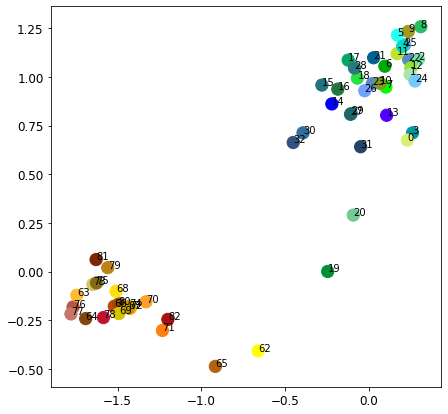

In [247]:
fig=plot_utils.plot_embedding(jsd_wv_emb_2d[~jsd_wv_emb_2d["subclass_label"].isin(["Pvalb", "Serpinf1","Sncg", "Vip", "Lamp5"])],
                              plot_dim=2,
                              plot_size=(7,7),
                              scatter_point_size=150,
                              annotation = True)
# fig.savefig("/Users/fahimehb/Documents/NPP_GNN_project/figures/sst_exc_2d_jsd.png", dpi=750)

In [170]:
jsd_wv_emb_2d.loc[['65', '75',]]

,Z0,Z1,cluster_color,dendcluster_label,dendcluster_id,cluster_label,colors,subclass_id,subclass_label,subclass_color,class_id,class_label,class_color
cluster_id,,,,,,,,,,,,,
65,-0.916952,-0.487057,#B06411,Sst Tac1 Tacr3,88,Sst Tac1 Tacr3,#B06411,5,Sst,#F15A29,1,GABAergic,#EF4136
75,-1.626025,-0.058494,#806B19,Sst Hpse Cbln4,98,Sst Hpse Cbln4,#806B19,5,Sst,#F15A29,1,GABAergic,#EF4136


In [548]:
fig.savefig("/Users/fahimehb/Documents/NPP_GNN_project/figures/MCBOW_p_1_q_1.png", dpi=350)

In [233]:
tmp_edge.sort_values(by=['weight'])

,source,target,weight
2401,27,62,0.000917
2341,26,62,0.001250
2421,27,87,0.001998
8255,27,40,0.002165
2521,29,62,0.002353
...,...,...,...
5939,62,28,4.832780
339,62,13,4.869793
1352,62,46,4.915162
1353,62,49,4.938443


### Survey walks

In [206]:
walk_filename = "walk_node21_32_removed.csv"
walks = {}
for p, q in [(0.01, 1000000), (1000000, 0.01)]:
    walk_dir = utils.get_walk_dir(roi=roi, 
                              project_name=project_name, 
                              N=N, 
                              length=length, 
                              p=p, 
                              q=q, 
                              layer_class=layer_class, 
                              layer=layer, 
                              walk_type=walk_type)

    walk_name = utils.get_walk_dir_name(N=1, p=p, q=q, length=length)
    walks[walk_name] = utils.read_list_of_lists_from_csv(os.path.join(walk_dir, walk_filename))

In [231]:
for i in range(93):
    print(i, tmp_edge[tmp_edge.source == str(i)].shape)

0 (91, 3)
1 (91, 3)
2 (91, 3)
3 (91, 3)
4 (91, 3)
5 (91, 3)
6 (91, 3)
7 (91, 3)
8 (91, 3)
9 (91, 3)
10 (91, 3)
11 (91, 3)
12 (91, 3)
13 (91, 3)
14 (91, 3)
15 (91, 3)
16 (91, 3)
17 (91, 3)
18 (91, 3)
19 (91, 3)
20 (91, 3)
21 (0, 3)
22 (91, 3)
23 (91, 3)
24 (91, 3)
25 (91, 3)
26 (91, 3)
27 (91, 3)
28 (91, 3)
29 (91, 3)
30 (91, 3)
31 (91, 3)
32 (0, 3)
33 (91, 3)
34 (91, 3)
35 (91, 3)
36 (91, 3)
37 (91, 3)
38 (91, 3)
39 (91, 3)
40 (91, 3)
41 (91, 3)
42 (91, 3)
43 (91, 3)
44 (91, 3)
45 (91, 3)
46 (91, 3)
47 (91, 3)
48 (91, 3)
49 (91, 3)
50 (91, 3)
51 (91, 3)
52 (91, 3)
53 (91, 3)
54 (91, 3)
55 (91, 3)
56 (91, 3)
57 (91, 3)
58 (91, 3)
59 (91, 3)
60 (91, 3)
61 (91, 3)
62 (91, 3)
63 (91, 3)
64 (91, 3)
65 (91, 3)
66 (91, 3)
67 (91, 3)
68 (91, 3)
69 (91, 3)
70 (91, 3)
71 (91, 3)
72 (91, 3)
73 (91, 3)
74 (91, 3)
75 (91, 3)
76 (91, 3)
77 (91, 3)
78 (91, 3)
79 (91, 3)
80 (91, 3)
81 (91, 3)
82 (91, 3)
83 (91, 3)
84 (91, 3)
85 (91, 3)
86 (91, 3)
87 (91, 3)
88 (91, 3)
89 (91, 3)
90 (91, 3)
91 (91, 3)


In [225]:
for _ in range(10):
    print("yes")

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


Checking all the weights on all the edges!
Computing the node importance!
[['0', '35', '12', '69', '9', '30', '7', '17', '55', '48'], ['2', '51', '28', '18', '13', '28', '22', '1', '85', '83'], ['9', '20', '48', '41', '43', '26', '3', '23', '36', '61'], ['11', '80', '10', '29', '78', '62', '66', '14', '70', '49'], ['13', '4', '25', '25', '75', '45', '6', '3', '35', '48'], ['36', '76', '9', '86', '3', '66', '60', '69', '57', '10'], ['43', '90', '89', '67', '92', '8', '24', '14', '47', '86'], ['47', '54', '31', '30', '43', '82', '49', '50', '35', '58'], ['48', '22', '92', '15', '44', '27', '2', '39', '24', '69'], ['53', '27', '79', '34', '68', '52', '92', '59', '30', '19'], ['54', '47', '81', '46', '8', '30', '2', '41', '9', '15'], ['58', '87', '35', '49', '57', '41', '9', '31', '23', '41'], ['62', '17', '28', '4', '26', '10', '5', '1', '30', '81'], ['63', '39', '79', '28', '7', '62', '86', '56', '67', '10'], ['64', '90', '7', '8', '67', '42', '25', '53', '73', '46'], ['67', '12', '17', 

In [209]:
print(walks['N_1_l_10000_p_0.01_q_1000000'][0][0:10])
print(walks['N_1_l_10000_p_1000000_q_0.01'][0][0:10])

['0', '15', '92', '27', '92', '17', '7', '12', '30', '30']
['0', '48', '14', '65', '52', '77', '59', '69', '54', '3']


### Plot loss for different embedding sizes

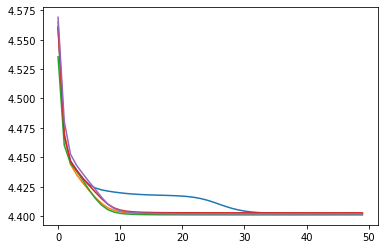

In [76]:
plt.plot(losses['p_1_q_1'])
plt.plot(losses['p_1_q_2'])
plt.plot(losses['p_2_q_1'])
plt.plot(losses['p_0.5_q_2'])
plt.plot(losses['p_2_q_0.5'])

### Check the difference between MCBOW and CBOW